In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
#PIL is Python Imaging Library
from PIL import Image
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
%matplotlib inline
from keras.layers import Input, Dense, InputLayer, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
import tensorflow as tf


Init Plugin
Init Graph Optimizer
Init Kernel


(396, 316, 3)


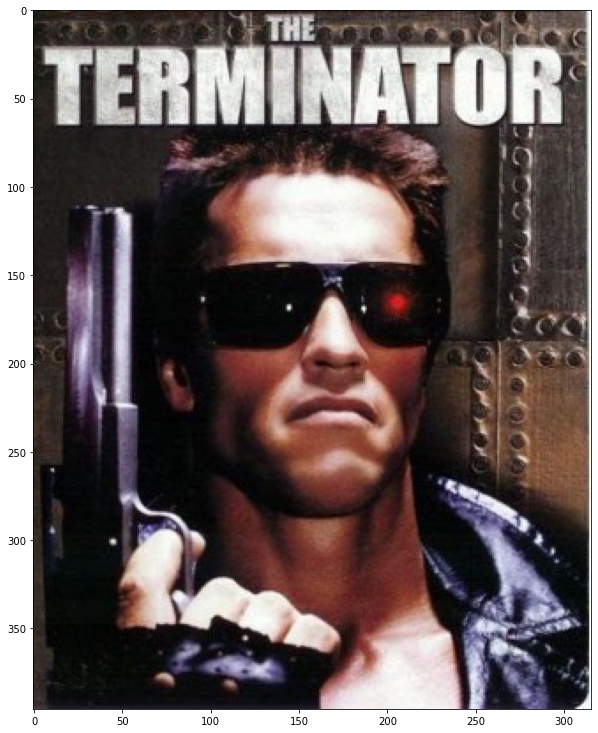

In [2]:
img = Image.open('The Terminator (1984).jpg')
plt.figure(figsize=(10,15))
plt.imshow(img, cmap=plt.cm.gray)
image_matrix = np.array(img)
print(image_matrix.shape)

In [3]:
X_org = image_matrix.copy()
sc = StandardScaler()
X = X_org.astype('float32')/ 255.0 - 0.5
input_img = Input(shape=(img.width,))
print (X.shape)

(396, 316, 3)


Set up a basic autoencoder.  Play around with the parameters and see how they perform.  Try adding/removing layers.

We give the autoencoder an image, of whatever dimensions.  The Terminator image is 396x316.  However, it's also an RGB image, so the actual dimensions are 396x316x3 = 375k. This is a really high dimensional dataset!

The encoder takes this high-D input and encodes it into a much lower dimensional space.  code_size is how many nodes we want to encode the image to - the more you have, the better the image reconstruction will be, as less compression (and less data loss) has occurred.  The decoder takes the output from the encoder, this new low-dimensional data, and reconstructs the original image.

In [4]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    # encoder.add(Dense(512, activation='relu'))
    encoder.add(Dense(128, activation='relu'))
    #encoder.add(Flatten())
    encoder.add(Dense(code_size, activation='relu'))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    #decoder.add(Flatten())
    decoder.add(Dense(128, activation='relu'))
    # decoder.add(Dense(512, activation='relu'))
    #encoder.add(Flatten())
    decoder.add(Dense(np.prod(img_shape), activation='relu')) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

encoder, decoder = build_autoencoder(X.shape, 1024)


Metal device set to: Apple M1


2021-10-14 14:48:48.218578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-14 14:48:48.218885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Different optimisers and loss function can be set up here - see how it changes things.

In [6]:
inp = Input(X.shape)
encoded = encoder(inp)
reconstructed = decoder(encoded)

autoencoder = Model(inp, reconstructed)
autoencoder.compile(
    optimizer='adam', 
    loss='mse', 
)

xarr = np.array([X])

The autoencoder has about 380k input parameters (the dimension of the problem).

In [11]:
print(autoencoder.summary())

KerasTensor(type_spec=TensorSpec(shape=(None, 396, 316, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), name='dense_4/BiasAdd:0', description="created by layer 'dense_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 396, 316, 3), dtype=tf.float32, name=None), name='reshape_1/Reshape:0', description="created by layer 'reshape_1'")
(1, 396, 316, 3)
KerasTensor(type_spec=TensorSpec(shape=(None, 396, 316, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 396, 316, 3), dtype=tf.float32, name=None), name='sequential_3/reshape_1/Reshape:0', description="created by layer 'sequential_3'")
Model: "model"
___________________________

Start training the autoencoder.  Note that this can be time consuming, depending on the hardware in your computer, how many epochs you set, and what code_size you specified earlier.  For reference, this takes about 7 or 8 minutes on my M1 Mac. 

In [8]:
train_res = autoencoder.fit(x=xarr, y=xarr, epochs=20, validation_data=(xarr, xarr), verbose=1)

2021-10-14 14:48:56.254421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-14 14:48:56.260392: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2021-10-14 14:49:03.382383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.1255

2021-10-14 14:49:16.521364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 27s 27s/step - loss: 0.1255 - val_loss: 0.0027
Epoch 2/20
1/1 [==============================] - 24s 24s/step - loss: 22.8197 - val_loss: 72.0352
Epoch 3/20
1/1 [==============================] - 27s 27s/step - loss: 72.0352 - val_loss: 378.1892
Epoch 4/20
1/1 [==============================] - 24s 24s/step - loss: 378.1892 - val_loss: 50.2448
Epoch 5/20
1/1 [==============================] - 20s 20s/step - loss: 50.2448 - val_loss: 39.0539
Epoch 6/20
1/1 [==============================] - 22s 22s/step - loss: 39.0539 - val_loss: 9.3764
Epoch 7/20
1/1 [==============================] - 20s 20s/step - loss: 9.3764 - val_loss: 61.3958
Epoch 8/20
1/1 [==============================] - 33s 33s/step - loss: 61.3958 - val_loss: 133.3299
Epoch 9/20
1/1 [==============================] - 25s 25s/step - loss: 133.3299 - val_loss: 530.4284
Epoch 10/20
1/1 [==============================] - 26s 26s/step - loss: 530.4284 - val_loss: 58.6010
Epoch 11/20
1/1 [=

2021-10-14 14:57:21.739074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-14 14:57:22.604677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


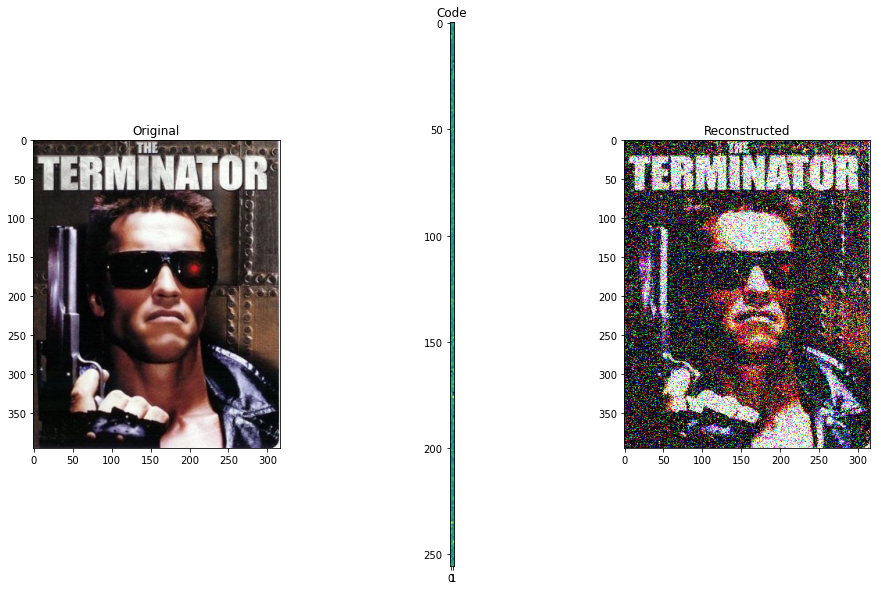

In [9]:
def plot_comparison(img, encoder, decoder):
    # Draws original, encoded and decoded images
    plt.figure(figsize=(15,10))
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original Image")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Encoded Image")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed Image")
    show_image(reco)
    plt.show()


plot_comparison(X, encoder, decoder)